In [1]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img_paths = glob.glob('../ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()

img_paths = img_paths[:5000]
img_paths[:2]

['../ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\0003a0755539c426ecfc7ed79bc74aeea6be740b.jpg',
 '../ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\000420107b8abee7c2f08bb21e4444a9d00c9323.jpg']

In [3]:
validation_annotations = json.load(
    open('../ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)

validation_annotations[:2]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [4]:
validation_annotations_dict = { x['image_id']: x['caption'][0] for x in validation_annotations }

img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

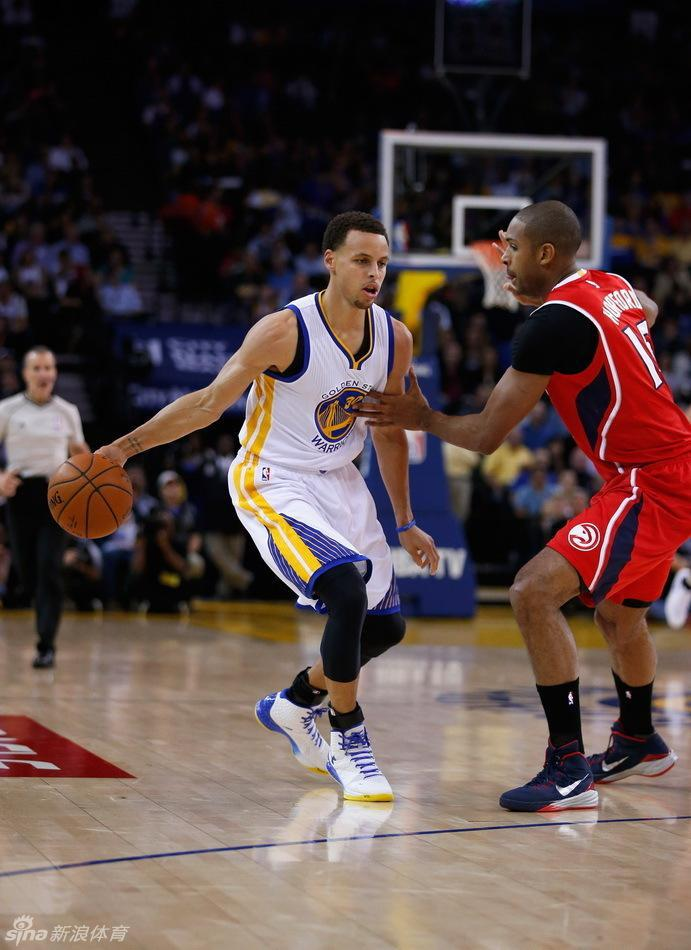

In [6]:
Image.open(img_paths[10])

In [7]:
img_captions[10]

'一个男人前面有两个穿着球衣的男人在平坦的球场上打篮球'

加载CLIP模型

In [8]:
from PIL import Image
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch
import requests

In [10]:
# CLIP中文模型
model = ChineseCLIPModel.from_pretrained('../models/chinese-clip-vit-base-patch16')
# 预处理
processor = ChineseCLIPProcessor.from_pretrained('../models/chinese-clip-vit-base-patch16')

图像编码

In [35]:
img_image_feat = []

batch_size = 100
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]

    if len(imgs) == 0:
        break

    inputs = processor(images=imgs, return_tensors='pt')
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)
    # break

img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7732\2589732273.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/51 [00:00<?, ?it/s]

In [36]:
img_image_feat.shape

(5000, 512)

文本编码

In [37]:
img_texts_feat = []

batch_size = 100
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break

    inputs = processor(text=texts, return_tensors='pt', padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    # break

img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7732\1226099671.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/51 [00:00<?, ?it/s]

In [38]:
img_texts_feat.shape

(5000, 512)

相似度计算

输入文本： 街道上走着一个面带微笑的女人


([], [])

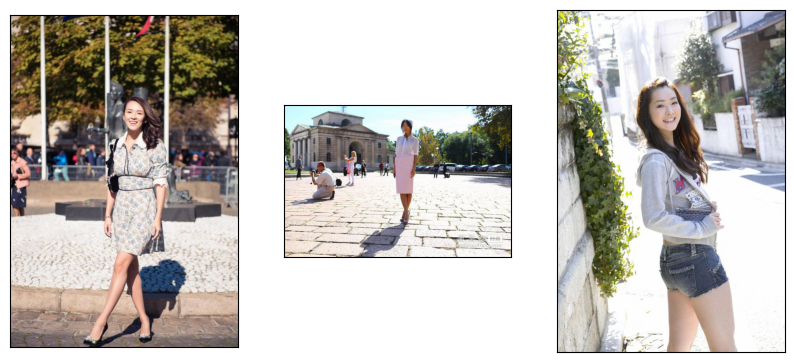

In [40]:
query_idx = 255

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

print('输入文本：', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

文本识别结果： ['宽敞的院子里站着一位左手拿包的女士', '一个右手拿着包的长发女人站在道路上', '一个右手拿着包的长发女人站在道路上']


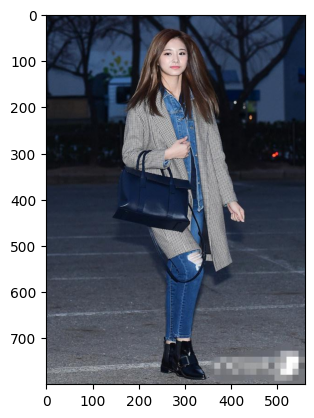

In [41]:
query_idx = 255

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果：', [img_captions[x] for x in sim_idx])

文本标签编码

In [27]:
import jieba

jieba.lcut('今天天气很好，心情也很好。')

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.619 seconds.
Prefix dict has been built successfully.


['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [29]:
jieba.lcut(img_captions[8])

['房间', '里', '有', '一个', '披', '着', '头发', '的', '女人', '和', '一个', '人', '在', '下围棋']

In [30]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

img_captions2words[:10]

['一个', '穿着', '裙子', '的', '女孩', '双手', '拿', '着', '东西', '站']

In [31]:
img_captions2words = [x for x in img_captions2words if len(x)>1]
img_captions2words = list(set(img_captions2words))

img_captions2words[:10]

['喂狗', '旁边', '拉扯', '手提包', '小孩子', '牛仔裙', '飞身', '老旧', '石凳', '抢球']

In [42]:
img_texts_feat = []

batch_size = 100
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break

    inputs = processor(text=texts, return_tensors='pt', padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)

img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7732\2565708335.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/21 [00:00<?, ?it/s]

文本识别结果： ['包在', '布着', '各挽着', '斜挎包', '包上', '旁包']


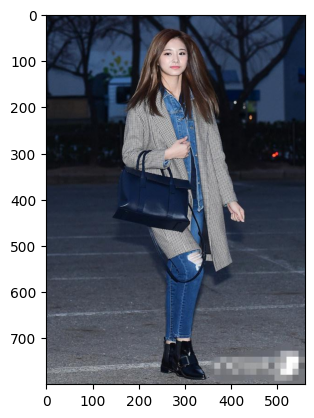

In [43]:
query_idx = 255

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果：', [img_captions2words[x] for x in sim_idx])